## **Welcome!**
Thank you for visiting our Colab submission for our manuscript titled "AI in the Loop - Functionalizing Fold Performance Disagreement to Monitor Automated Medical Image Segmentation Pipelines."

#**Overview**
In this work, we detail a method for using individual folds from a 5-fold CNN model (implemented using the nn-UNet framework) to identify predictions that need to be flagged. Our primary application of this method is for robust quality control in unmonitored workflows.

#**Validation**
We validated our approach by comparing the summarized interfold dice metrics to final ensemble performance. Please note that this validation would not be possible without reference standards.

We hope you find our work interesting and informative!


##**Methodology**
To describe our work, we:

1. Trained an ensemble nn-UNet model on an internal dataset from a radical nephrectomy database.
2, Used each fold model and the final ensemble model to make prediction segmentations on each test image.
3. Calculated the Dice metric between each fold model for each image (10 comparisons in total: fold 1 vs. fold 2, fold 1 vs. fold 3, etc.).
4. Summarized the interfold Dice scores and compared them to human interobserver values. We flagged any scores below the interobserver threshold for human review.
5. Validated the association between lower interfold Dice agreement and lower ensemble performance by comparing the interfold Dice agreement with the final ensemble Dice between the reference standard and the ensemble model.

In [2]:
# Packages and functions

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import time
import seaborn as sns
import nibabel as nib
import math
import os
import copy
from functools import partial, reduce
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns; sns.set_theme()
sns.set(font_scale=2)

def plot_matrix(cm, classes, title, savepath):
  plt.figure(figsize=(10,10))
  axp = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False, fmt='g')
  axp.set(title=title, xlabel="Median Interfold < Threshold", ylabel="Ensemble < Threshold")
  axp.figure.savefig(savepath)

def dice(array1, array2):

	array1 = array1.astype(bool).copy()
	array2 = array2.astype(bool).copy()

	intersection = np.logical_and(array1, array2)

	if (array1.sum()) == 0 or (array2.sum() == 0):
		return 0
	else:
		return 2. * intersection.sum() / (array1.sum() + array2.sum())   

#**Setting up Directories and Paths**
We start by setting up directories and paths to the predicted segmentation for each image in different folders by fold.

See the nn-UNet github for how to run the framework: https://github.com/MIC-DKFZ/nnUNet

We made predictions for individual folds using the -f flag in the prediction command.

In this case, we focused on predicting tumors and set the corresponding label of 2 to not include predicting kidney parenchyma.

We derived the human interobserver threshold for CT tumors from Rasmussen, Robert, et al. "Artificial Intelligence in Kidney Cancer." American Society of Clinical Oncology Educational Book 42 (2022): 300-310.

In [3]:
# Directories and set important variables

interfold_test_prediction_folders = ['/content/drive/MyDrive/Frontiers_Data/fold0_predictions/','/content/drive/MyDrive/Frontiers_Data/fold1_predictions/', '/content/drive/MyDrive/Frontiers_Data/fold2_predictions/', '/content/drive/MyDrive/Frontiers_Data/fold3_predictions/', '/content/drive/MyDrive/Frontiers_Data/fold4_predictions/']
test_ensemble_metrics = pd.read_csv('/content/drive/MyDrive/Frontiers_Data/LABEL_2_similarity_metrics_CT_300_kits21_folde.csv')
project_title = 'CT_internal_predict_kits'
root_folder = '/content/drive/MyDrive/Frontiers_Data/analysis_results_folder/'

output_folder = root_folder + project_title + '/'
intermediate_folder = output_folder + '/intermediate_sim_metrics/'

if not os.path.exists(output_folder):
	os.mkdir(output_folder)
	os.mkdir(intermediate_folder)

io = 0.90  # io threshold to compare Interfold dice against
label = 2  # set label for comparison on -- 2 in this case is kidney tumor

#**Calculating Dice Similarity Metrics**
Next, we calculated the dice between each fold for each image to create the LABEL_2_confidence_dice_similarity_metrics.csv file.

In [5]:
# Calculate Interfold Dice-wise metrics

# suffix to remove from 'ID' column in fold simlarity metrics so can merge on 'ID' between interfold csv and test csv
remove_suffix = '.nii.gz'

#1) CALCULATE INTERFOLD DICE AND WRITE OUT SUMMARY TABLE


table = pd.DataFrame({'ID': pd.Series([], dtype ='str'),
								 'Dice_comp': pd.Series([], dtype ='float'),
								 'pred_folder0': pd.Series([], dtype ='str'),
								 'pred_folder1': pd.Series([], dtype ='str')})

comparisons = combinations(interfold_test_prediction_folders, 2)
n_comp = 0

for comp in comparisons:

	print('on comp # ' + str(n_comp))

	n_comp+=1

	pred0 = comp[0]
	pred1 = comp[1]

	print(pred0)
	print(pred1)

 	# load in arrays
	subdir, dirs, all_files = os.walk(pred0).__next__()
	all_files = [f for f in all_files if remove_suffix in f]
	strremove = -len(remove_suffix)

	for file in all_files:

		prediction0_seg = nib.load(pred0 + '/' + file)
		prediction0_affine = prediction0_seg.affine
		prediction0_seg_data = prediction0_seg.get_fdata()

		prediction1_seg = nib.load(pred1 + '/' + file)
		prediction1_affine = prediction1_seg.affine
		prediction1_seg_data = prediction1_seg.get_fdata()

		label_prediction_seg_data = copy.deepcopy(prediction0_seg_data)
		label_reference_seg_data = copy.deepcopy(prediction1_seg_data)

		label_prediction_seg_data[label_prediction_seg_data != label] = 0
		label_prediction_seg_data[label_prediction_seg_data == label] = 1

		label_reference_seg_data[label_reference_seg_data!= label] = 0
		label_reference_seg_data[label_reference_seg_data== label] = 1

		dice_score = dice(label_prediction_seg_data, label_reference_seg_data)

		# update table
		row = {'ID': file[:strremove], 'Dice_comp': dice_score, 'pred_folder0': pred0, 'pred_folder1': pred1}
		table = pd.concat([table, pd.DataFrame(row, index=[0])], ignore_index=True)

table.to_csv(intermediate_folder + 'LABEL_' + str(label) + '_confidence_dice_similarity_metrics.csv')


on comp # 0
/content/drive/MyDrive/Frontiers_Data/fold0_predictions/
/content/drive/MyDrive/Frontiers_Data/fold1_predictions/
on comp # 1
/content/drive/MyDrive/Frontiers_Data/fold0_predictions/
/content/drive/MyDrive/Frontiers_Data/fold2_predictions/
on comp # 2
/content/drive/MyDrive/Frontiers_Data/fold0_predictions/
/content/drive/MyDrive/Frontiers_Data/fold3_predictions/
on comp # 3
/content/drive/MyDrive/Frontiers_Data/fold0_predictions/
/content/drive/MyDrive/Frontiers_Data/fold4_predictions/


FileNotFoundError: ignored

#**Summarizing Interfold Dices**
Then, we summarized the dices (10 each between the 5 models) with different metrics to create the LABEL_2_confidence_interfold_dice_df.csv file.

In [ ]:
# Calculate summary metrics

table = pd.read_csv(intermediate_folder + 'LABEL_' + str(label) + '_confidence_dice_similarity_metrics.csv')

#mean
mean = table.groupby('ID')['Dice_comp'].mean().to_frame()
mean['metric'] = 'mean'
#median
median = table.groupby('ID')['Dice_comp'].median().to_frame()
median['metric'] = 'median'
#min
min = table.groupby('ID')['Dice_comp'].min().to_frame()
min['metric'] = 'min'
#max
max = table.groupby('ID')['Dice_comp'].max().to_frame()
max['metric'] = 'max'
#std
std = table.groupby('ID')['Dice_comp'].std().to_frame()
std['metric'] = 'std'
#range
range = table.groupby('ID')['Dice_comp'].max() - table.groupby('ID')['Dice_comp'].min()
range = range.to_frame()
range['metric'] = 'range'

summarized_interfold_dice_df = pd.concat([mean, median, max, min, std, range], axis=0)
summarized_interfold_dice_df.to_csv(intermediate_folder + 'LABEL_' + str(label) + '_confidence_interfold_dice_df.csv')

#**Validating the Results**
As mentioned above, in this case we had reference standards available to calculate the final ensemble test performance. This was used to validate our method.

The proposed use case of this method is in workflow where reference standards are not available, however, investigators may want to validate their specific use case by having some reference standards available before implementing this method in an unsupervised format. 

In [ ]:
# Read in final ensemble metrics to create tables and figures

test_ensemble_metrics = test_ensemble_metrics[['ID','Dice']]
interfold_ensemble_metrics = pd.merge(test_ensemble_metrics, summarized_interfold_dice_df, on = 'ID', how = 'right')
interfold_ensemble_metrics.to_csv(intermediate_folder + 'comparison_interfold_ensemble_label_' + str(label) + '.csv')

A key validation test was to see how cohort dice changed between the total, flagged, and unflagged cohort. 

Impressively, you can see that the total test cohort has a poor dice score (mean 0.641 sd 0.377) while the unflagged cohort performs near human interobserver value (mean .85-.91 sd .07-.17). 

You can also see how different choices in summary metrics affect how many images will be flagged and the performance between the flagged and non-flagged sets. Minimum of the interfold set needing to be above the threshold represents the most strict criteria where the most images will be flagged and the unflagged performance will be best, while maximum represents the converse. In our analysis, median tended to be the best metrics to balance performance with not flagging too many images. 

In [ ]:
# TABLE 5 

interfold_ensemble_metrics = pd.read_csv(intermediate_folder + 'comparison_interfold_ensemble_label_' + str(label) + '.csv')

metrics = ['mean','median','max','min']
c_interfold_ensemble_metrics = copy.deepcopy(interfold_ensemble_metrics)

table = pd.DataFrame({'Method': pd.Series([], dtype ='str'),
								 'Mean All Images': pd.Series([], dtype ='float'),
								 'SD All Images': pd.Series([], dtype ='float'),
								 'N Flag Images': pd.Series([], dtype ='float'),
								 'Mean Flag Images': pd.Series([], dtype ='float'),
								 'SD Flag Images': pd.Series([], dtype ='float'), 
								 'Mean WO Flag Images': pd.Series([], dtype ='float'),
								 'SD WO Flag Images': pd.Series([], dtype ='float')})

for met in metrics:

	print(met)
	interfold_ensemble_metrics = copy.deepcopy(c_interfold_ensemble_metrics)
	interfold_ensemble_metrics = interfold_ensemble_metrics[interfold_ensemble_metrics['metric'] == met]
	mean_all = np.round(interfold_ensemble_metrics['Dice'].mean(),3)
	sd_all = np.round(interfold_ensemble_metrics['Dice'].std(),3)
	mean_flagged = np.round(interfold_ensemble_metrics.loc[interfold_ensemble_metrics['Dice_comp']<io]['Dice'].mean(),3)
	sd_flagged = np.round(interfold_ensemble_metrics[interfold_ensemble_metrics['Dice_comp']<io]['Dice'].std(),3)
	mean_wo_flagged = np.round(interfold_ensemble_metrics.loc[interfold_ensemble_metrics['Dice_comp']>io]['Dice'].mean(),3)
	sd_wo_flagged = np.round(interfold_ensemble_metrics[interfold_ensemble_metrics['Dice_comp']>io]['Dice'].std(),3)
	num_flag = interfold_ensemble_metrics[interfold_ensemble_metrics['Dice_comp']<io].shape[0]
	row = {'Method': met, 'Mean All Images':mean_all, 'SD All Images' : sd_all,'N Flag Images': num_flag, 'Mean Flag Images': mean_flagged, 'SD Flag Images': sd_flagged, 'Mean WO Flag Images': mean_wo_flagged, 'SD WO Flag Images': sd_wo_flagged}
	table = table.append(row, ignore_index = True)

print(table)
table.to_csv(output_folder + 'table5.csv')

mean
median
max
min
   Method  Mean All Images  SD All Images  N Flag Images  Mean Flag Images  \
0    mean            0.641          0.377          143.0             0.369   
1  median            0.641          0.377          135.0             0.338   
2     max            0.641          0.377           87.0             0.132   
3     min            0.641          0.377          175.0             0.453   

   SD Flag Images  Mean WO Flag Images  SD WO Flag Images  
0           0.380                0.889              0.107  
1           0.369                0.890              0.102  
2           0.238                0.849              0.167  
3           0.394                0.905              0.073  


<ipython-input-12-76a5bd228990>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(row, ignore_index = True)
<ipython-input-12-76a5bd228990>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(row, ignore_index = True)
<ipython-input-12-76a5bd228990>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(row, ignore_index = True)
<ipython-input-12-76a5bd228990>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(row, ignore_index = True)


In the 4-pane graph of the different metrics:

* the blue dash is IO threshold for flagging - below this line the 
predictions are flagged
* the red dash line is the final ensemble test performance set at the IO value- right of this line is considered "good performance"

<Figure size 640x480 with 0 Axes>

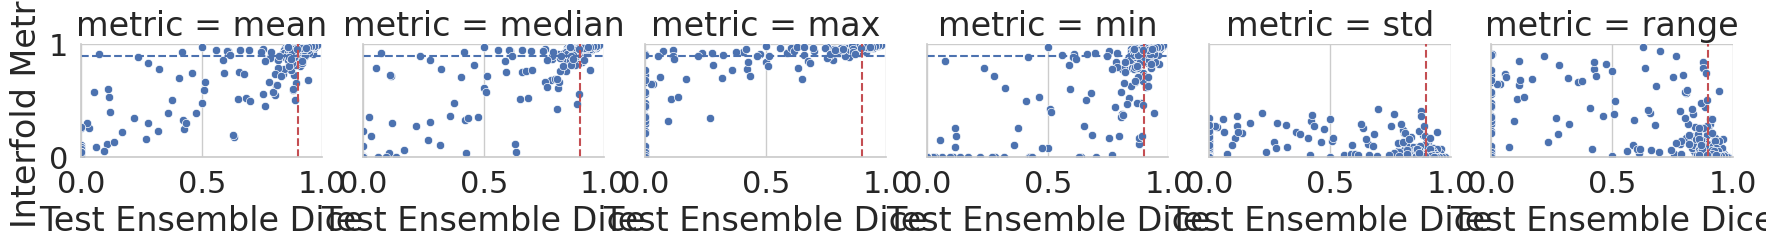

In [ ]:
# FIGURE 3a - 4-pane summary metric comparisons

interfold_ensemble_metrics = pd.read_csv(intermediate_folder + 'comparison_interfold_ensemble_label_' + str(label) + '.csv')

sns.set_style("whitegrid")
plt.figure()

p2 = sns.FacetGrid(interfold_ensemble_metrics, col="metric")
p2.map(sns.scatterplot, "Dice", "Dice_comp")
p2.set_axis_labels("Test Ensemble Dice", "Interfold Metric")
p2.set(xlim=(0, 1),ylim=(0, 1))

ax1, ax2, ax3, ax4, ax5, ax6 = p2.axes[0][:6]

ax1.axhline(io, ls='--')
ax2.axhline(io, ls='--')
ax3.axhline(io, ls='--')
ax4.axhline(io, ls='--')

ax1.axvline(io, ls='--', color = 'r')
ax2.axvline(io, ls='--', color = 'r')
ax3.axvline(io, ls='--', color = 'r')
ax4.axvline(io, ls='--', color = 'r')
ax5.axvline(io, ls='--', color = 'r')
ax6.axvline(io, ls='--', color = 'r')

plt.savefig(output_folder + 'FIGURE3a.png')

We also created confusion metrics to investigate true postives, false positives, false negatives, and true negatives. 

*   True positive is defined as when flagged images (summary Interfold Dice < threshold) performed poorly (test ensemble < threshold). 
*   True Negative is defined as when non-flagged images (summary Interfold Dice > threshold) performed well (test ensemble > threshold). 
*   False positives defined as when flagged images (summary Interfold Dice < threshold) performed well (test ensemble > threshold). 
*   False negatives defined as when non-flagged images (summary Interfold Dice > threshold) performed poorly (test ensemble < threshold).

In [ ]:
# FIGURE 3b - confusion matrix

conf_mat = pd.read_csv(intermediate_folder + 'comparison_interfold_ensemble_label_' + str(label) + '.csv')
conf_mat = conf_mat.loc[conf_mat['metric'] == 'median']
print(conf_mat)
# true positives - where ensemble < threshold and < interfold
tp = conf_mat.loc[(conf_mat['Dice'] < io) & (conf_mat['Dice_comp'] < io)].shape[0]

# false positives - where ensemble > threshold and < interfold
fp = conf_mat.loc[(conf_mat['Dice'] < io) & (conf_mat['Dice_comp'] > io)].shape[0]

# false negative - where ensemble < threshold and > interfold
fn = conf_mat.loc[(conf_mat['Dice'] > io) & (conf_mat['Dice_comp'] < io)].shape[0]

# true negative - where ensemble > threshold and > interfold
tn = conf_mat.loc[(conf_mat['Dice'] > io) & (conf_mat['Dice_comp'] > io)].shape[0]

classes = ['Positive', 'Negative']
confusion_matrix = np.array([[tp, fp], [fn, tn]])
title = project_title + ' LABEL ' + str(label) + '\n true label + if ensemble > ' + str(io) + '\n predicted label + if median of interfold > ' + str(io)

plot_matrix(confusion_matrix, classes, title, output_folder + 'figure3b.png')


NameError: ignored